https://opg.optica.org/ol/fulltext.cfm?uri=ol-44-6-1492&id=407286

For z-CUT LNOI: no for the quasi-TE mode and ne for the quasi-TM mode, despite propagation direction

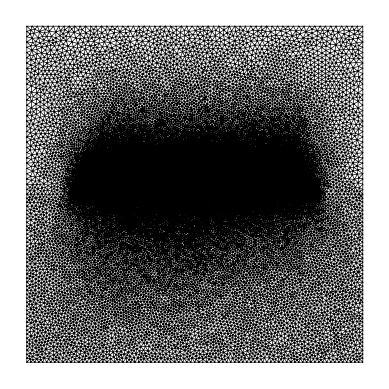

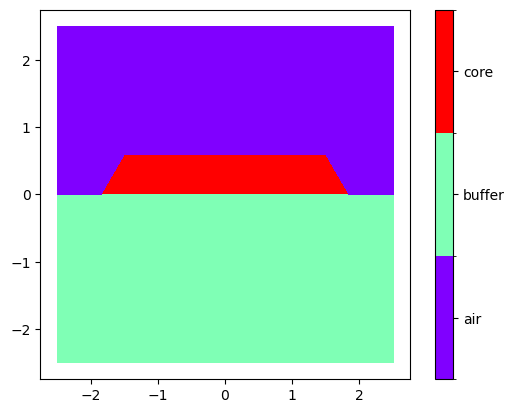

start


  0%|          | 0/1 [00:00<?, ?it/s]

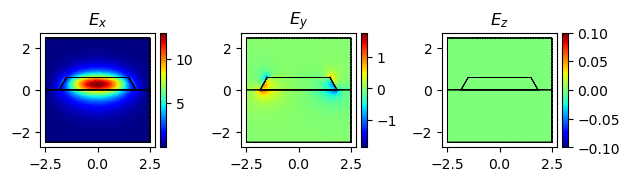

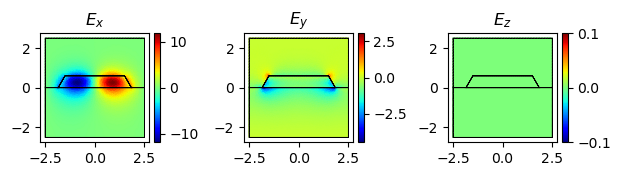

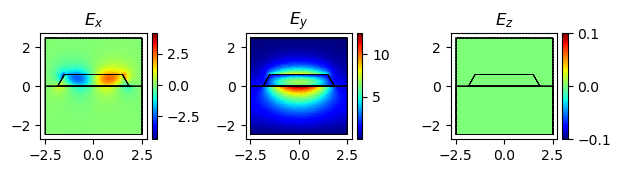

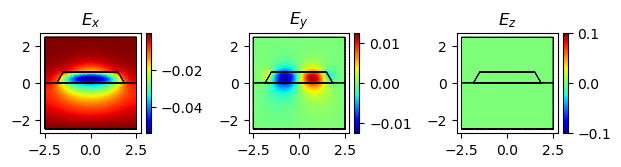

100%|██████████| 1/1 [00:42<00:00, 42.81s/it]

[5.27544458]
[1.46871125]
[2.51964452]
[1.71482123]


In [1]:

import math

from skfem import Basis, ElementTriP0
from tqdm import tqdm
from femwell.mesh import mesh_from_OrderedDict
from skfem.io import from_meshio
from femwell.visualization import plot_domains
import shapely
from femwell.maxwell.waveguide import compute_modes
from refractive_index import n_SiO2, n_Air, n_LNOI
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon

wavelength_range = [500, 3100]
wavelegnth_step = 70
ray = "o"

n_core = lambda w: n_LNOI(w, ray=ray)
n_buffer = n_SiO2
n_air = n_Air

# waveguide parameters
#bottom_width = 2 # um
top_width = 3
box_height = 5
triangle_height = 0.6
triangle_width = triangle_height / math.tan(60 * math.pi / 180)

# Construct waveguide geometry
core = Polygon(
    [(top_width / 2 + triangle_width, 0), (-top_width / 2 - triangle_width, 0), (-top_width / 2, triangle_height),
     (top_width / 2, triangle_height)])
buffer = shapely.geometry.box(-box_height / 2, -box_height / 2, box_height / 2, 0)
air = shapely.geometry.box(-box_height / 2, 0, box_height / 2, box_height / 2)

polygon = OrderedDict(
    core=core,
    buffer=buffer,
    air=air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.02, "distance": 0.1},
                   buffer={"resolution": 0.06, "distance": 0.5},
                   air={"resolution": 0.08, "distance": 0.5})

n_dict = {"core": n_core, "buffer": n_buffer, "air": n_air}

mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
mesh.draw().show()
plot_domains(mesh)
plt.show()

#----------------------FEM solver-------------------------------
print("start")
# Calculate dispersion and gamma
mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = np.array([3000])
neff_list_te = []
aeff_list_te = []
neff_list_tm = []
aeff_list_tm = []

for wavelength in tqdm(wavelength_list):
    wavelength = wavelength * 1e-3
    for subdomain, n in n_dict.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2
    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)

    ## te mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.n_eff))
    mode = modes_sorted[0]
    neff_list_te.append(np.real(mode.n_eff))
    aeff_list_te.append(mode.calculate_effective_area())
    mode.show(mode.E.real, direction="x")
    modes_sorted[1].show(modes_sorted[1].E.real, direction="x")
    modes_sorted[2].show(modes_sorted[2].E.real, direction="x")

    ## tm mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.tm_fraction))
    if modes_sorted[0].tm_fraction < 0.7:
        print(f"at {wavelength}um, mode has highest tm_fraction of f{modes_sorted[0].tm_fraction}")
    mode = modes_sorted[0]
    neff_list_tm.append(np.real(mode.n_eff))
    aeff_list_tm.append(mode.calculate_effective_area())
    mode.show(mode.H.real, direction="x")

neff_list_te = np.array(neff_list_te)
aeff_list_te = np.array(aeff_list_te)

neff_list_tm = np.array(neff_list_tm)
aeff_list_tm = np.array(aeff_list_tm)
wls = np.array(wavelength_list)
print(aeff_list_tm)
print(neff_list_tm)
print(aeff_list_te)
print(neff_list_te)


Plot the effective refractive index and calculate the GVD and dispersion operator

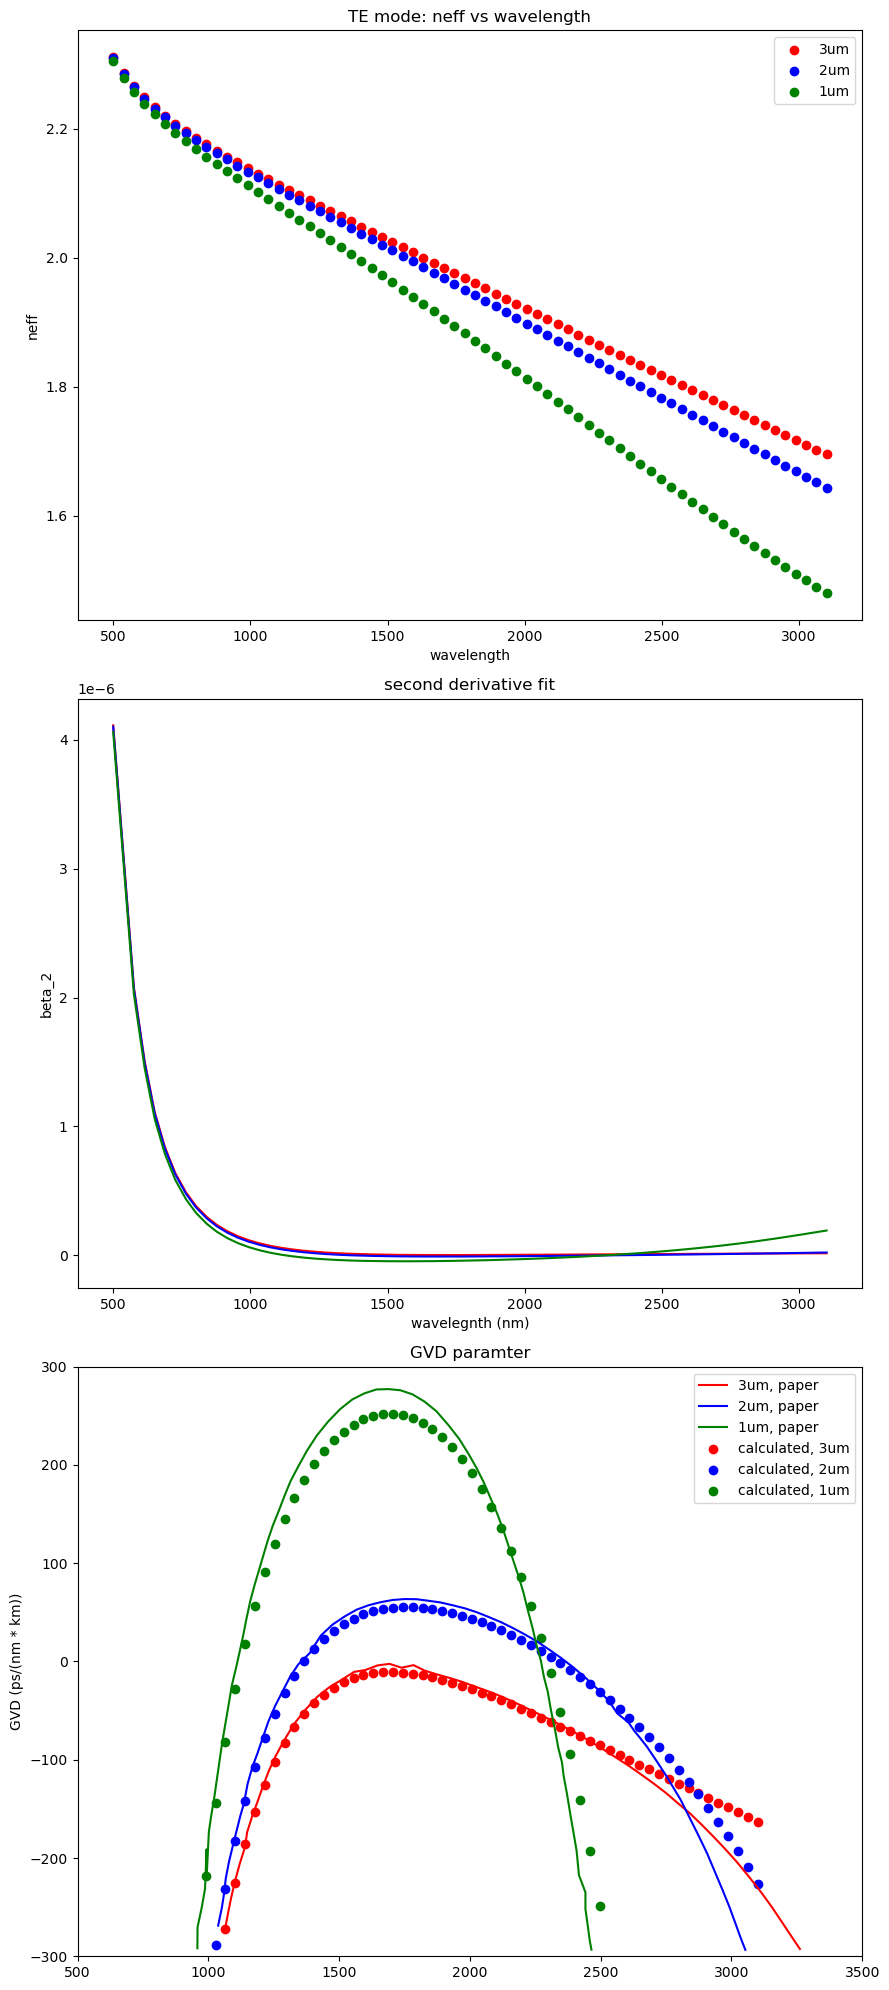

In [18]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c
import pandas as pd

top_width = 2
box_height = 5
triangle_height = 0.6

data_2um = np.load(f"data_h_{0.6}_w_{2}_o.npz")
data_1um = np.load(f"data_h_{0.6}_w_{1}_o.npz")
data_3um = np.load(f"data_h_{0.6}_w_{3}_o.npz")

neff_list_3um = np.array(np.real(data_3um['neff_list_te']))
neff_list_2um = np.array(np.real(data_2um['neff_list_te']))
neff_list_1um = np.array(np.real(data_1um['neff_list_te']))

wls_3um = data_3um["wls"]
wls_2um = data_2um["wls"]
wls_1um = data_1um["wls"]

fig, axs = plt.subplots(3, 1, figsize=(9, 20))

#-----------fit neff spline----------------------------------
y_spl_3um = UnivariateSpline(wls_3um, neff_list_3um, s=0, k=3)
y_spl_2um = UnivariateSpline(wls_2um, neff_list_2um, s=0, k=3)
y_spl_1um = UnivariateSpline(wls_1um, neff_list_1um, s=0, k=3)
w_range = np.linspace(wls_2um[0], wls_2um[-1], 1000)

#-----------neff plot-----------------
axs[0].set_xlabel("wavelength")
axs[0].set_ylabel("neff")
axs[0].set_title("TE mode: neff vs wavelength")
axs[0].scatter(wls_3um, neff_list_3um, color="red", label="3um")
axs[0].scatter(wls_2um, neff_list_2um, color="blue", label="2um")
axs[0].scatter(wls_1um, neff_list_1um, color="green", label="1um")
axs[0].legend()

#-----------second derivative plot-----------------
y_spl_2d_3um = y_spl_3um.derivative(n=2)
y_spl_2d_2um = y_spl_2um.derivative(n=2)
y_spl_2d_1um = y_spl_1um.derivative(n=2)
axs[1].set_xlabel("wavelegnth (nm)")
axs[1].set_ylabel("beta_2")
axs[1].set_title("second derivative fit")
axs[1].plot(w_range, y_spl_2d_3um(w_range), color="red")
axs[1].plot(w_range, y_spl_2d_2um(w_range), color="blue")
axs[1].plot(w_range, y_spl_2d_1um(w_range), color="green")

#-----------plot reference data __________________
ref_3um = pd.read_csv("../reference_data/3um.csv", dtype=np.float64)
ref_3um_x, ref_3um_y = np.split(ref_3um.values, 2, axis=1)
axs[2].plot(ref_3um_x, ref_3um_y, c="red", label="3um, paper")

ref_2um = pd.read_csv("../reference_data/2um.csv", dtype=np.float64)
ref_2um_x, ref_2um_y = np.split(ref_2um.values, 2, axis=1)
axs[2].plot(ref_2um_x, ref_2um_y, c="blue", label="2um, paper")

ref_1um = pd.read_csv("../reference_data/1um.csv", dtype=np.float64)
ref_1um_x, ref_1um_y = np.split(ref_1um.values, 2, axis=1)
axs[2].plot(ref_1um_x, ref_1um_y, c="green", label="1um, paper")

#-----------GVD plot---------------------------
GVD_3um = (-wls_3um / (2.99792e-7) * y_spl_2d_3um(wls_3um))
GVD_2um = (-wls_2um / (2.99792e-7) * y_spl_2d_2um(wls_2um))
GVD_1um = (-wls_1um / (2.99792e-7) * y_spl_2d_1um(wls_2um))

axs[2].scatter(wls_3um, GVD_3um, label="calculated, 3um", c="red")
axs[2].scatter(wls_2um, GVD_2um, label="calculated, 2um", c="blue")
axs[2].scatter(wls_1um, GVD_1um, label="calculated, 1um", c="green")

axs[2].set_ylabel("GVD (ps/(nm * km))")
axs[2].set_ylim(-300, 300)
axs[2].set_xlim(500, 3500)
axs[2].set_title("GVD paramter")
axs[2].legend()

plt.tight_layout()
plt.show()

   1.0% - 1.010e-04 m - 0.0 seconds
   2.0% - 2.020e-04 m - 0.1 seconds
   3.0% - 3.030e-04 m - 0.1 seconds
   4.0% - 4.040e-04 m - 0.1 seconds
   5.1% - 5.051e-04 m - 0.1 seconds
   6.1% - 6.061e-04 m - 0.1 seconds
   7.1% - 7.071e-04 m - 0.1 seconds
   8.1% - 8.081e-04 m - 0.1 seconds
   9.1% - 9.091e-04 m - 0.1 seconds
  10.1% - 1.010e-03 m - 0.1 seconds
  11.1% - 1.111e-03 m - 0.1 seconds
  12.1% - 1.212e-03 m - 0.1 seconds
  13.1% - 1.313e-03 m - 0.1 seconds
  14.1% - 1.414e-03 m - 0.1 seconds
  15.2% - 1.515e-03 m - 0.1 seconds
  16.2% - 1.616e-03 m - 0.2 seconds
  17.2% - 1.717e-03 m - 0.2 seconds
  18.2% - 1.818e-03 m - 0.2 seconds
  19.2% - 1.919e-03 m - 0.2 seconds
  20.2% - 2.020e-03 m - 0.2 seconds
  21.2% - 2.121e-03 m - 0.2 seconds
  22.2% - 2.222e-03 m - 0.2 seconds
  23.2% - 2.323e-03 m - 0.2 seconds
  24.2% - 2.424e-03 m - 0.2 seconds
  25.3% - 2.525e-03 m - 0.2 seconds
  26.3% - 2.626e-03 m - 0.2 seconds
  27.3% - 2.727e-03 m - 0.2 seconds
  28.3% - 2.828e-03 m - 0.2 

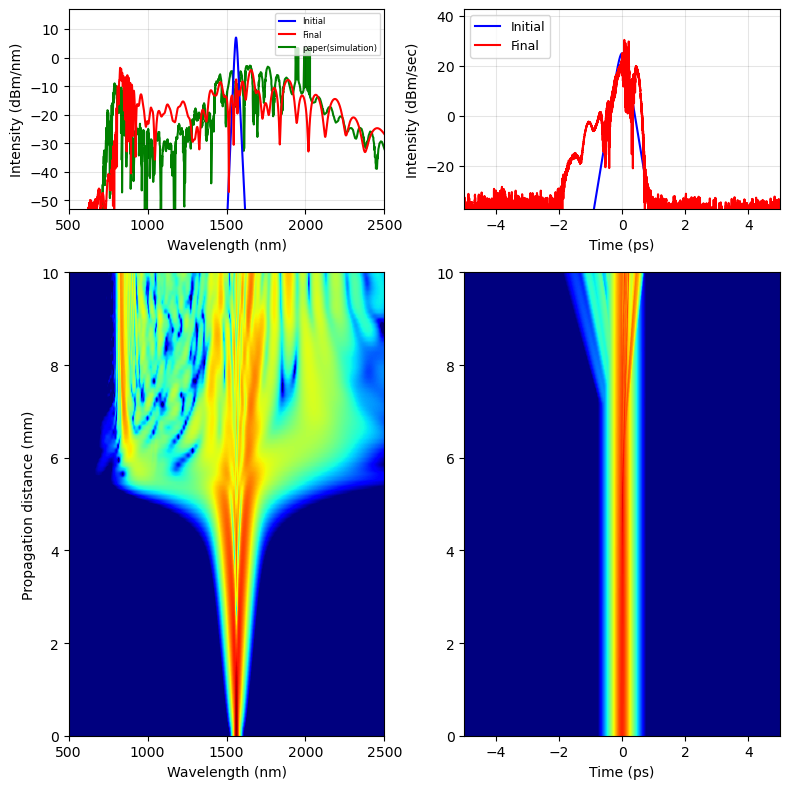

In [3]:
import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c

# pulse parameters
FWHM = 200 * 1e-3  # pulse duration (ps)
pulseWL = 1560  # pulse central wavelength (nm)
length = 10 * 1e-3
# about 909 pj

power = 4000  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion
rep_rate = 80 * 1e6  # rep rate in hz

# simulation parameters
Window = 10  # simulation window (ps)
Steps = 100  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4  # absolute error
Raman = False  # Enable Raman effect?
Steep = True  # Enable self steepening?

ray = "o"
top_width = 1.75  # um
box_height = 5
triangle_height = 0.6
# ----------- Build Waveguide -----------
n2 = 1e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.16  # loss (dB/cm)

data = np.load(f"data_h_{triangle_height}_w_{top_width}_{ray}.npz")
wls = data['wls']
neff_list = data['neff_list_te']
aeff_list = data['aeff_list_te']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(pump_wl, wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list, fill_value=(aeff_list[0], aeff_list[-1]),
                                             bounds_error=False)
    gamma = 2 * np.pi * n2 / (wl * 1e-9 * aeff_interp(wl) * 1e-12)
    return gamma


gamma = gamma_function(pulseWL, pulseWL)

# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, power_is_avg=False, power=power, GDD=GDD, TOD=TOD, FOD=FOD,
             npts=Points)
p.add_noise()
# create the waveguide
f = lf.Fiber(length, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma, loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)
fig, axes = results.plot(wavelength=True, show=False, tlim=(-5, 5), flim=(500, 2500), units="dBm/nm", rep_rate=rep_rate,
                         cparam=[50, 60])

#------------- Plot reference -----------
ref = pd.read_csv(
    "../reference_data/Figure2.csv", dtype=np.float64
)
ref_x, ref_y = np.split(ref.values, 2, axis=1)

axes[0][0].plot(ref_x, ref_y + 15, c="green", label="paper(simulation)", zorder=0)
axes[0][0].legend(loc="upper right", prop={'size': 6}, fontsize=8)

plt.set_cmap('jet')
plt.show()


Propagate laser to the waveguide using pynlo

1.4084362939352107e-21
z: 1/100
z: 2/100
Discarded
Discarded
z: 3/100
z: 4/100
z: 5/100
z: 6/100
z: 7/100
z: 8/100
z: 9/100
z: 10/100
z: 11/100
z: 12/100
z: 13/100
z: 14/100
z: 15/100
z: 16/100
z: 17/100
z: 18/100
z: 19/100
z: 20/100
z: 21/100
z: 22/100
z: 23/100
z: 24/100
z: 25/100
z: 26/100
z: 27/100
z: 28/100
z: 29/100
z: 30/100
z: 31/100
z: 32/100
z: 33/100
z: 34/100
z: 35/100
z: 36/100
z: 37/100
z: 38/100
z: 39/100
z: 40/100
z: 41/100
z: 42/100
z: 43/100
z: 44/100
z: 45/100
z: 46/100
z: 47/100
z: 48/100
z: 49/100
z: 50/100
z: 51/100
z: 52/100
z: 53/100
z: 54/100
z: 55/100
z: 56/100
z: 57/100
z: 58/100
z: 59/100
z: 60/100
z: 61/100
z: 62/100
z: 63/100
Discarded
Discarded
Discarded
Discarded
z: 64/100
z: 65/100
z: 66/100
z: 67/100
z: 68/100
z: 69/100
z: 70/100
z: 71/100
z: 72/100
z: 73/100
z: 74/100
z: 75/100
z: 76/100
z: 77/100
z: 78/100
z: 79/100
z: 80/100
z: 81/100
z: 82/100
z: 83/100
z: 84/100
z: 85/100
z: 86/100
z: 87/100
z: 88/100
z: 89/100
z: 90/100
z: 91/100
z: 92/100
z: 93/

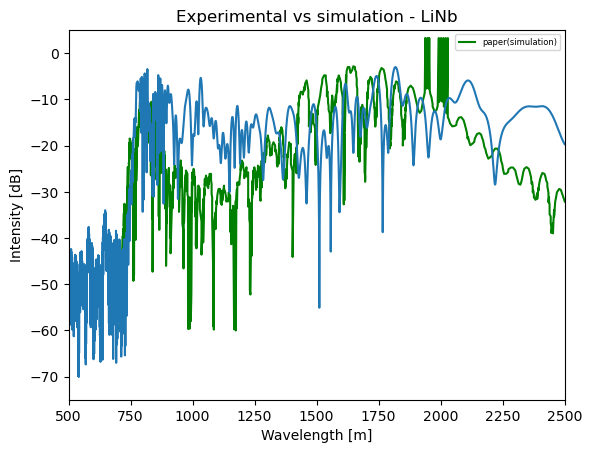

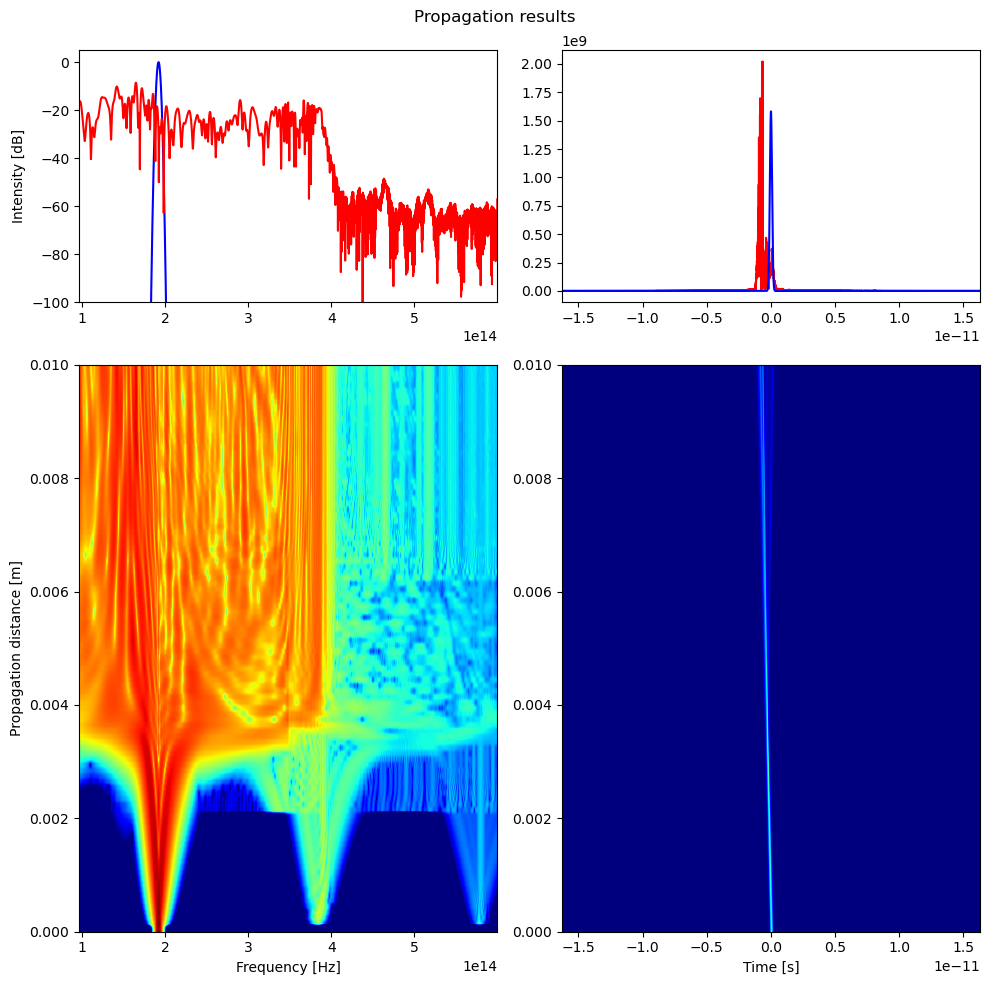

<Figure size 640x480 with 0 Axes>

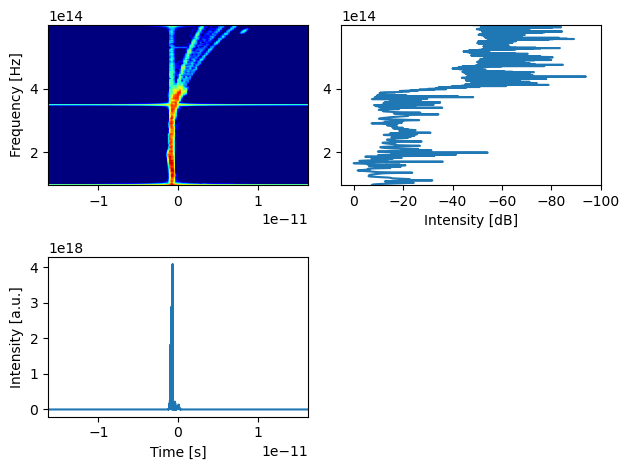

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c
import pandas as pd
import pychi
import scipy

eps_0 = 8.8541878128e-12

"""
User parameters
"""
### Simulation
t_pts = 2 ** 14

### Light
pulse_duration = 200 * 1e-15
pulse_wavelength = 1.56e-06
pulse_power = 4000
pulse_energy = pulse_power * pulse_duration / 0.88

###Load data
ray = "o"
top_width = 1.75  # um
triangle_height = 0.6

data = np.load(f"data_h_{triangle_height}_w_{top_width}_{ray}.npz")
wg_freq = c / (data['wls'] * 1e-9)
wg_neff = data['neff_list_te']
aeff_list = data['aeff_list_te'] * 1e-12

aeff_interp = scipy.interpolate.interp1d(data['wls'] * 1e-9, aeff_list)
neff_interp = scipy.interpolate.interp1d(wg_freq, wg_neff)
wg_aeff = aeff_interp(pulse_wavelength)

### Waveguide
wg_length = 10 * 1e-3
wg_chi_2 = 8.4e-12
n2 = 1e-19


def wg_chi_3(z, freq):
    return 4 / 3 * neff_interp(freq) ** 2 * c * n2 * eps_0


print(wg_chi_3(0, c / pulse_wavelength))

### Prepare waveguide
waveguide = pychi.materials.Waveguide(wg_freq, wg_neff, wg_chi_2, wg_chi_3,
                                      wg_aeff, wg_length, t_pts=t_pts)

### Prepare input pulse
pulse = pychi.light.Gaussian(waveguide, pulse_duration, pulse_energy, pulse_wavelength)

### Prepare model
model = pychi.models.SpmChi2Chi3(waveguide, pulse)

### Prepare solver, solve
solver = pychi.solvers.Solver(model, z_pts=100)
solver.solve()

# Plot

plt.figure()
plt.plot(pulse.wl * 1e9, 20 * np.log10(pulse.spectrum_wl[-1] / np.amax(pulse.spectrum_wl[-1])) - 3)
plt.xlim(500, 2500)
plt.ylim(-75, 5)
plt.title('Experimental vs simulation - LiNb')
plt.xlabel('Wavelength [m]')
plt.ylabel('Intensity [dB]')
plt.legend(('Simulation', 'Experiment'))
plt.savefig('Experimental_vs_simulation_LiNb.png')

#------------- Plot reference -----------

ref = pd.read_csv(
    "../reference_data/Figure2.csv", dtype=np.float64
)
ref_x, ref_y = np.split(ref.values, 2, axis=1)

plt.plot(ref_x, ref_y + 15, c="green", label="paper(simulation)", zorder=0)
plt.legend(loc="upper right", prop={'size': 6}, fontsize=8)

plt.set_cmap('jet')
plt.show()
pulse.plot_propagation("pychi")
# Results can also be accessed via pulse.z_save, pulse.freq, pulse.spectrum, pulse.waveform
# The refractive index and GVD can be seen with waveguide.plot_refractive_index()

[0.17944949 0.17954232 0.17963518 ... 1.79024531 1.7903466  1.79044789]


C:\Users\eliza\anaconda3\envs\SC-generation-stimulation\Lib\site-packages\pynlo\model.py:617: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self._rt_fig.show()
C:\Users\eliza\AppData\Local\Temp\ipykernel_34924\2804880397.py:96: RuntimeWarning: divide by zero encountered in log10
  p_t_dB = 10*np.log10(np.abs(a_t)**2)


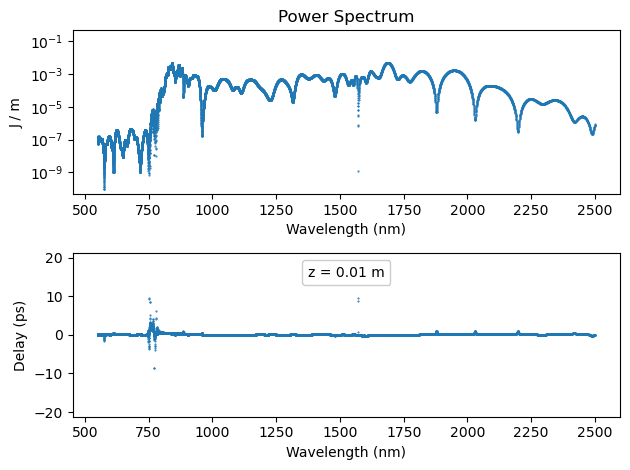

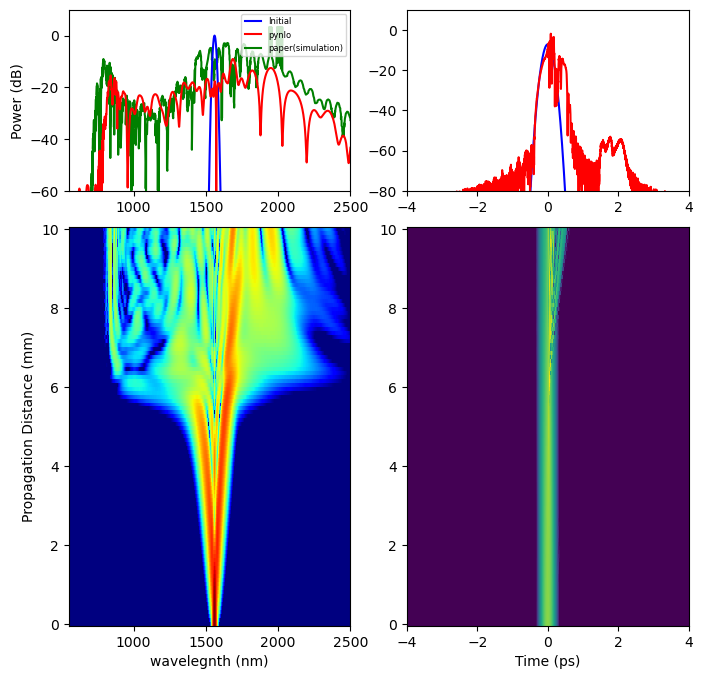

In [7]:
import numpy as np
import pynlo
from scipy.constants import pi, c
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi, c
from matplotlib import pyplot as plt
import pandas as pd
import pynlo
from pynlo import utility as ut

# ---- Pulse parameter
n_points = 2 ** 14
center_wl = 1560 * 1e-9
start_wl = 550 * 1e-9
end_wl = 2500 * 1e-9

peak_power = 4000
t_fwhm = 200e-15  # for sech, fwhm = 1.76 * pulse duration 
e_p = peak_power * t_fwhm / 0.88

f_min = c / (end_wl)  # c / l
f_max = c / (start_wl)  # c / l
f0 = c / center_wl  # c / 

pulse = pynlo.light.Pulse.Gaussian(n_points, f_min, f_max, f0, e_p, t_fwhm,
                                   alias=2)  # alias = number of harmonic support by the real-valued time domain grid

ray = "o"
top_width = 1.75  # um
box_height = 5
triangle_height = 0.6

data = np.load(f"data_h_{triangle_height}_w_{top_width}_{ray}.npz")
wls = data['wls'] * 1e-9
neff_list = data['neff_list_te']
aeff_list = data['aeff_list_te']

aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
neff_interp = scipy.interpolate.interp1d(wls, neff_list)

length = 10e-3  # 10 mm
a_eff = aeff_interp(center_wl) * 1e-12

#---- Phase Coefficient
w_grid = c / pulse.v_grid
n_eff = neff_interp(w_grid)
beta = n_eff * 2 * pi * pulse.v_grid / c

#---- 2nd-order nonlinearity
chi2_eff = 4.3e-12 * 2  # pm / V
g2 = ut.chi2.g2_shg(f0, pulse.v_grid, n_eff, a_eff, chi2_eff)

# 3rd-Order Nonlinearity
n2 = 1e-19


def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * aeff_interp(pump_wl) * 1e-12)
    return gamma


gamma = gamma_function(w_grid)  #1/(W*m)
print(gamma)
g3 = ut.chi3.gamma_to_g3(pulse.v_grid, gamma)

mode = pynlo.medium.Mode(pulse.v_grid, beta, g3=g3, g2=g2)

#----build model
model = pynlo.model.UPE(pulse, mode)

#---- Estimate step size
local_error = 1e-6
dz = model.estimate_step_size(local_error=local_error)

pulse_out, z, a_t, a_v = model.simulate(length, dz=dz, local_error=local_error, n_records=100, plot="wvl")

fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3, 2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=2, sharex=ax1)

p_v_dB = 10 * np.log10(np.abs(a_v) ** 2)
p_v_dB -= p_v_dB.max()

w_grid = c / (pulse.v_grid) * 1e9
ax0.plot(w_grid, p_v_dB[0], color="b", label='Initial')
ax0.plot(w_grid, p_v_dB[-1], color="r", label="pynlo")
ax2.pcolormesh(w_grid, 1e3 * z, p_v_dB,
               vmin=-40.0, vmax=0, shading="auto", cmap="jet")
ax0.set_ylim(bottom=-60, top=10)
ax2.set_xlabel('wavelegnth (nm)')

p_t_dB = 10 * np.log10(np.abs(a_t) ** 2)
p_t_dB -= p_t_dB.max()
ax1.plot(1e12 * pulse.t_grid, p_t_dB[0], color="b", label='Initial')
ax1.plot(1e12 * pulse.t_grid, p_t_dB[-1], color="r")
ax3.pcolormesh(1e12 * pulse.t_grid, 1e3 * z, p_t_dB,
               vmin=-40.0, vmax=0, shading="auto")

ax1.set_ylim(bottom=-80, top=10)
ax1.set_xlim(-4, 4)
ax3.set_xlabel('Time (ps)')

ax0.set_ylabel('Power (dB)')
ax2.set_ylabel('Propagation Distance (mm)')
#------------- Plot reference -----------

ref = pd.read_csv(
    "../reference_data/Figure2.csv", dtype=np.float64
)
ref_x, ref_y = np.split(ref.values, 2, axis=1)

ax0.plot(ref_x, ref_y + 15, c="green", label="paper(simulation)", zorder=0)
ax0.legend(loc="upper right", prop={'size': 6}, fontsize=8)

plt.set_cmap('jet')
plt.show()
